In [3]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/"
%cd /content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD


In [11]:
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install geopandas==0.6.3 --quiet
!pip install descartes --quiet

# Folium 
!pip install folium

# Rasterio
!pip install Rasterio

# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,626 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.13.3-2ub

In [19]:
# 1. Download the repo and set it as the current directory
%cd /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD
!git clone https://github.com/avanetten/cresi.git
%cd /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD

/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD
fatal: destination path 'cresi' already exists and is not an empty directory.
/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD


In [ ]:
!python /content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/cresi/cresi/data_prep/create_8bit_images.py \
    --indir=/content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/data/Train/PS-MS \
    --outdir=/content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB \
    --rescale_type=perc \
    --percentiles=2,98 \
    --band_order=5,3,2

In [3]:
!python /content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/cresi/cresi/data_prep/speed_masks.py \    --geojson_dir=/content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/data/Train/AOI_3_Paris/geojson_roads_speed \
    --image_dir='/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/PS-MS' \
    --output_conversion_csv_contin=/content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/data/Train \
    --output_mask_dir_contin='/content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/data/Train/train_mask_continuous' \
    --buffer_distance_meters=2

import complete
      burn_val  speed
0     0.000000      0
1     3.923077      1
2     7.846154      2
3    11.769231      3
4    15.692308      4
..         ...    ...
61  239.307692     61
62  243.230769     62
63  247.153846     63
64  251.076923     64
65  255.000000     65

[66 rows x 2 columns]
/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train True
1 / 310 image: SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif geojson: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/AOI_3_Paris/geojson_roads_speed/SN3_roads_train_AOI_3_Paris_geojson_roads_speed_img10.geojson
inGDF.columns: Index(['heading', 'lane_number', 'one_way_ty', 'paved', 'road_id', 'road_type',
       'origarea', 'origlen', 'partialDec', 'truncated', 'bridge_type',
       'inferred_speed_mph', 'inferred_speed_mps', 'geometry'],
      dtype='object')
gdf_buffer['geometry'].values[0]: MULTIPOLYGON (((2.19187060596646 49.04713559783097, 2.192237413280601 49.04675550021506, 2.192404835043914 49

In [13]:
from osgeo import gdal
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import os, sys
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K
import json

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
import skimage
from matplotlib import pyplot as plt

seed = 56

In [5]:
|def Imagesload(path):
    imagesList = sorted(os.listdir(path))
    allImages = []
    allImages = [i for i in imagesList if i.endswith('.tif')]
    return allImages

In [6]:
images_path = "/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/"
masks_path = "/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/train_mask_continuous/"

images = Imagesload(images_path)
masks = Imagesload(masks_path)

# your images in an array
images_array = np.array([np.array(Image.open(images_path+fname)) for fname in images])
masks_array = np.array([np.array(Image.open(masks_path+fname)) for fname in masks])

In [7]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3

In [8]:
print(images_array.shape,masks_array.shape)

(310, 1300, 1300, 3) (310, 1300, 1300)


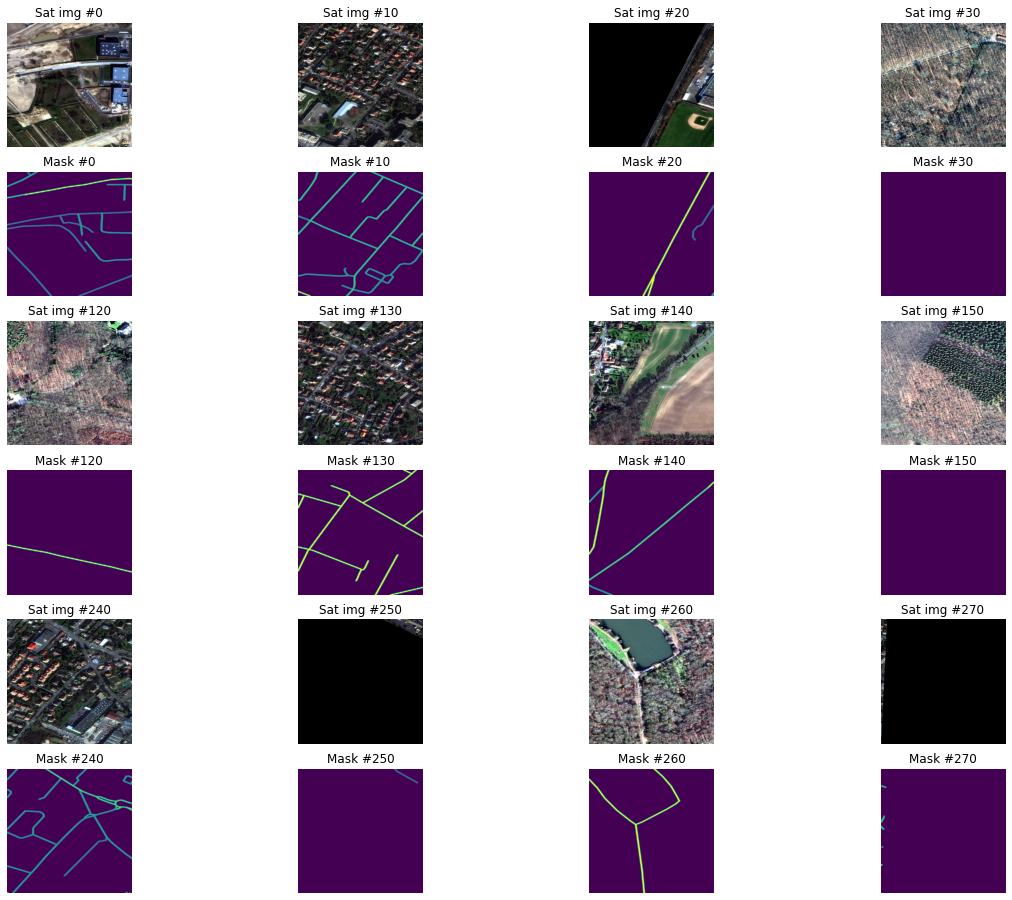

In [9]:
plt.figure(figsize=(20,16))
x, y = 4,3
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images_array[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks_array[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [5]:
cresi_dir = '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/'
src_dir = os.path.join(cresi_dir, 'cresi/cresi')
config_dir = os.path.join(cresi_dir, 'cresi/cresi/configs')
weight_dir = os.path.join(cresi_dir, 'data')
test_im_raw_dir = os.path.join(cresi_dir, 'data/Test/PS-MS')
test_im_clip_dir = os.path.join(cresi_dir, 'data/Test/PS-MS_clip')
test_final_dir = os.path.join(cresi_dir, 'data/Train/8bit/PS-RGB')
results_root_dir = os.path.join(cresi_dir, 'results')
results_dir = os.path.join(results_root_dir, 'dar_tutorial_cpu')
mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')
# make dirs
for d in [weight_dir, test_im_raw_dir, test_im_clip_dir, test_final_dir]:
    os.makedirs(d, exist_ok=True)

In [11]:
# Clip the image extent
ulx, uly, lrx, lry = 39.25252, -6.7580, 39.28430, -6.7880  # v0

im_name = [z for z in os.listdir(test_im_raw_dir) if z.endswith('.tif')][0]
print("im_name:", im_name)
test_im_raw = os.path.join(test_im_raw_dir, im_name)
test_im_clip = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip.tif')
print("output_file:", test_im_clip)

!gdal_translate -projwin {ulx} {uly} {lrx} {lry} '{test_im_raw}' '{test_im_clip}'

im_name: SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif
output_file: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Test/PS-MS_clip/SN3_roads_train_AOI_3_Paris_PS-MS_img10_clip.tif
Input file size is 1300, 1300
Warning 1: Computed -srcwin 1.37262e+07 2.06694e+07 11770 11111 falls completely outside raster extent. Going on however.
0...10...20...30...40...50...60...70...80...90...100 - done.


/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi/data_prep
im_files: ['SN3_roads_train_AOI_3_Paris_PS-MS_img10_clip.tif', 'SN3_roads_train_AOI_3_Paris_PS-MS_img237_clip.tif']
bmin, bmax: 0 0
zero_frac =  1.0
bmin, bmax: 0 0
zero_frac =  1.0
bmin, bmax: 0 0
zero_frac =  1.0
bmin, bmax: 0 0
zero_frac =  1.0
Pre-Raster cmd :  ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-a_nodata', '0', '-co', '"PHOTOMETRIC=rgb"', '-b 5', '-scale_1', '1', '0.0', '0', '255', '-b 3', '-scale_2', '1', '0.0', '0', '255', '-b 2', '-scale_3', '1', '0.0', '0', '255']
Conversion_command list: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-a_nodata', '0', '-co', '"PHOTOMETRIC=rgb"', '-b 5', '-scale_1', '1', '0.0', '0', '255', '-b 3', '-scale_2', '1', '0.0', '0', '255', '-b 2', '-scale_3', '1', '0.0', '0', '255']
Conversion_command str: gdal_translate -ot Byte -of GTiff -a_nodata 0 -co "PHOTOMETRIC=rgb" -b 5 -scale_1 1 0.0 0 255 -b 3 -scale_2 1 0.0 0 255 -b 2 -scale_3 1 0.0 0 255 "/con

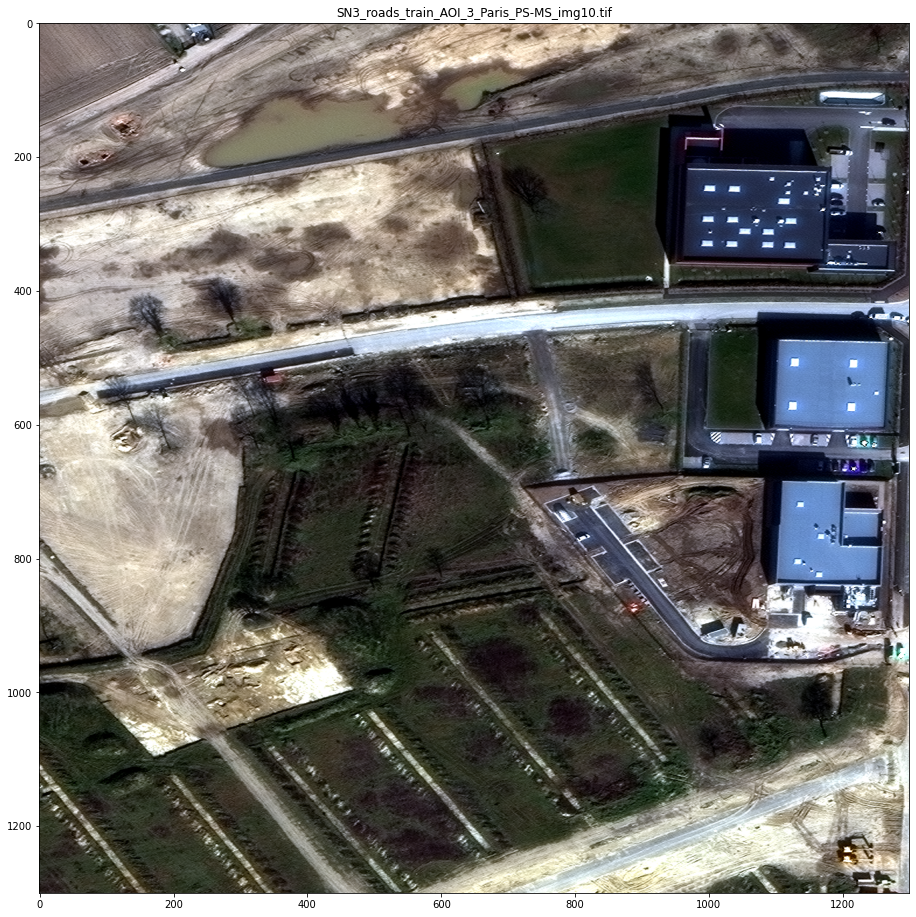

In [12]:
# Convert 16-bit multispectral test data to 8-bit RGB
%cd /content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/cresi/cresi/data_prep/
import create_8bit_images

create_8bit_images.dir_to_8bit(test_im_clip_dir, test_final_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[5,3,2])

# display our test image
fig_width, fig_height = 16, 16
im_test_name = [z for z in os.listdir(test_final_dir) if z.endswith('.tif')][0]
im_test_path = os.path.join(test_final_dir, im_test_name)
im_test = skimage.io.imread(im_test_path)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(im_test)
_ = ax.set_title(im_test_name)

In [6]:
config_path = os.path.join(config_dir, 'dar_tutorial_cpu.json')
print("config path:", config_path)
os.path.isfile(config_path)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    data['path_results_root'] = results_root_dir
    data['speed_conversion_file'] = os.path.join(config_dir, 'speed_conversion_binned7.csv')
    data['save_weights_dir'] = os.path.join(weight_dir, 'weights') 
    data['test_data_refined_dir'] = test_final_dir
    data['test_sliced_dir'] = test_final_dir + '_sliced'
    data['test_results_dir'] = 'dar_tutorial_cpu'
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

print("config data:")
data

config path: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi/configs/dar_tutorial_cpu.json
config data:


{'GSD': 0.3,
 'batch_size': 12,
 'default_val_perc': 0.2,
 'early_stopper_patience': 5,
 'epoch_size': 8,
 'eval_cols': 1344,
 'eval_rows': 1344,
 'folds_file_name': 'folds4.csv',
 'folds_save_dir': 'folds',
 'graph_dir': 'graphs',
 'ignore_target_size': False,
 'intersection_band': -1,
 'iter_size': 1,
 'log_to_console': 0,
 'loss': {'focal': 0.75, 'soft_dice': 0.25},
 'lr': 0.00015,
 'lr_gamma': 0.2,
 'lr_steps': [20, 25],
 'merged_dir': 'merged',
 'min_spur_length_m': 12,
 'min_subgraph_length_pix': 600,
 'nb_epoch': 70,
 'network': 'resnet34',
 'num_channels': 3,
 'num_classes': 8,
 'num_folds': 1,
 'optimizer': 'adam',
 'padding': 22,
 'path_results_root': '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results',
 'path_src': '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi',
 'predict_batch_size': 1,
 'rdp_epsilon': 1,
 'save_weights_dir': '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/weights',
 'skeleton_band': 7,
 'skeleton_dir': 'sk

In [35]:
!cp -av /content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB /content/drive/My\ Drive/Colab\ Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB_sliced

'/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB' -> '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB_sliced'
'/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/SN3_roads_train_AOI_3_Paris_PS-MS_img10_clip.tif' -> '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB_sliced/SN3_roads_train_AOI_3_Paris_PS-MS_img10_clip.tif'
'/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/SN3_roads_train_AOI_3_Paris_PS-MS_img237_clip.tif' -> '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB_sliced/SN3_roads_train_AOI_3_Paris_PS-MS_img237_clip.tif'
'/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif' -> '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB_sliced/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif'
'/content/drive/My Drive/C

In [15]:
!pip install osmnx

     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 1.0MB 35.4MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 10.3MB 48.1MB/s 
ERROR: pysal 2.4.0 has requirement urllib3>=1.26, but you'll have urllib3 1.25.11 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Rtree 0.8.3
    Uninstalling Rtree-0.8.3:
      Successfully uninstalled Rtree-0.8.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
  

In [15]:
import osmnx

In [39]:
%cd /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
%run -i 02_eval.py configs/dar_tutorial_cpu.json

/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
Executing inference with GPUs
Run utils.update_config()...
Updated config: OrderedDict([('path_src', '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi'), ('path_results_root', '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results'), ('save_weights_dir', '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/weights'), ('num_channels', 3), ('network', 'resnet34'), ('skeleton_thresh', 0.25), ('use_medial_axis', 0), ('min_subgraph_length_pix', 600), ('min_spur_length_m', 12), ('rdp_epsilon', 1), ('skeleton_band', 7), ('intersection_band', -1), ('early_stopper_patience', 5), ('num_folds', 1), ('default_val_perc', 0.2), ('train_data_refined_dir_ims', ''), ('train_data_refined_dir_masks', ''), ('speed_conversion_file', '/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi/configs/speed_conversion_binned7.csv'), ('folds_file_name', 'folds4.csv'), ('test_data_refined_dir', '/

  0%|          | 0/490 [00:00<?, ?it/s]

  model: Resnet34_upsample(
  (bottlenecks): ModuleList(
    (0): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (3): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (decoder_stages): ModuleList(
    (0): UnetDecoderBlock(
      (layer): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): R

100%|██████████| 490/490 [06:55<00:00,  1.18it/s]

Time to run 1 folds for 312 = 427.89867186546326 seconds


mask_pred.shape: (8, 1300, 1300)


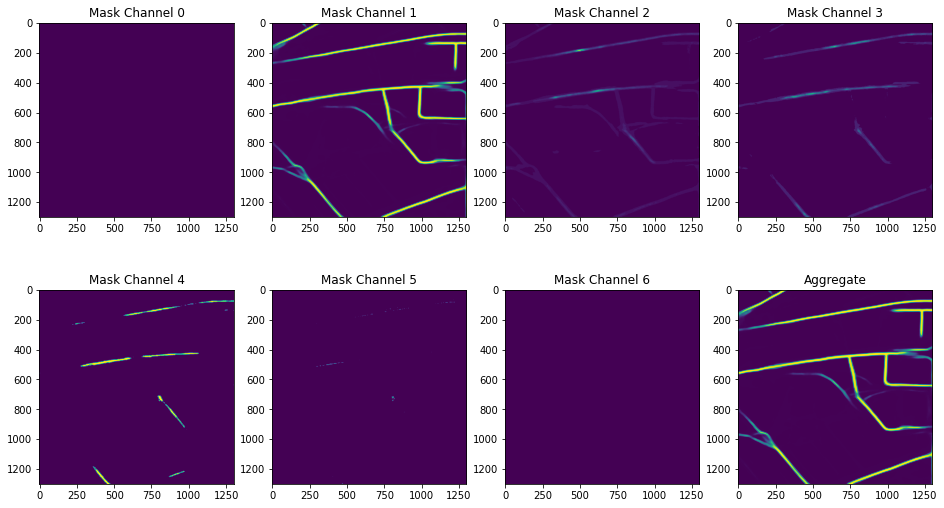

In [37]:
# inspect
mask_pred_file = 'fold0_SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif'
mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

In [50]:
%cd /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi/
%run -i data_prep/tile_im.py configs/dar_tutorial_cpu.json

/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
Output path for sliced images: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB_sliced
Slicing images in: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB
im_path: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif
im.shape: (1300, 1300, 3)
n pixels: 1690000
im_path: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/SN3_roads_train_AOI_3_Paris_PS-MS_img100.tif
im.shape: (1300, 1300, 3)
n pixels: 1690000
im_path: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/SN3_roads_train_AOI_3_Paris_PS-MS_img101.tif
im.shape: (1300, 1300, 3)
n pixels: 1690000
im_path: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/data/Train/8bit/PS-RGB/SN3_roads_train_AOI_3_Paris_PS-MS_img103.tif
im.shape: (1300, 1300, 3)
n pixels: 1690000
im_path: /

In [51]:
%cd {src_dir}
%run -i 03b_stitch.py configs/dar_tutorial_cpu.json

/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
Running stitch.py...
post_process_image - w, h: 1300 1300
0 / 1
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 1
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 1300, 1300)
mask_norm.dtype: uint8
post_process_image - w, h: 1300 1300
0 / 1
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 1
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 1300, 1300)
mask_norm.dtype: uint8
post_process_image - w, h: 1300 1300
0 / 1
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 1
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 1300, 1300)
mask_norm.dtype: uint8
post_process_imag

mask_pred.shape: (8, 1300, 1300)


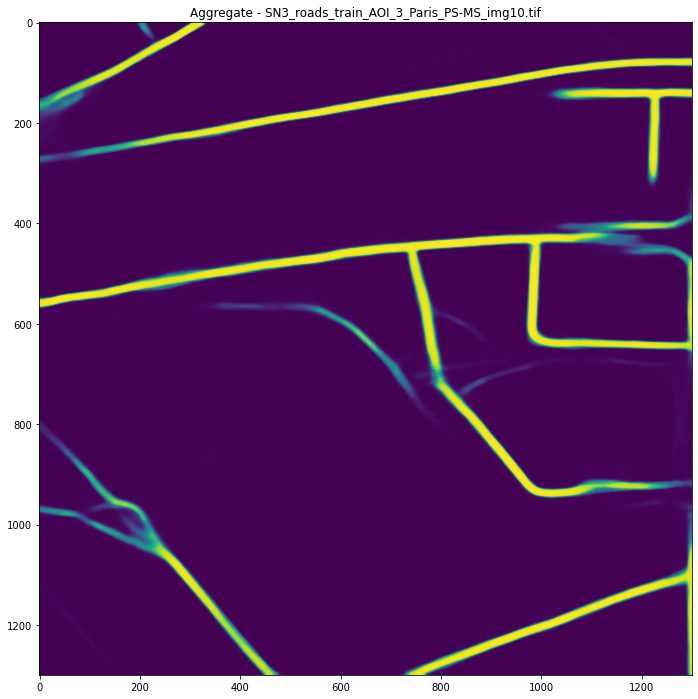

In [52]:
plot_all_layers = False
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

# plot all layers (optional)
if plot_all_layers:
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    for i, ax in enumerate(axes.flatten()):
        if i < (len(axes.flatten()) - 1):
            title = 'Mask Channel {}'.format(str(i))
        else:
            title = 'Aggregate' 
        ax.imshow(mask_pred[i,:,:])
        ax.set_title(title)

In [55]:
!pip install utm

  Created wheel for utm: filename=utm-0.7.0-cp37-none-any.whl size=6110 sha256=3fa88b8ff3af10b9670e6faee5bf1b21ff846dd2a04af7038d1d51e8ecb0d89c
  Stored in directory: /root/.cache/pip/wheels/d3/a0/c4/93c7535fe705e70d2376505fd2683f91524a50a944a15212d9
Successfully built utm


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
%run -i 04_skeletonize.py configs/dar_tutorial_cpu.json

/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
min_spur_length_pix: 40
Use_medial_axis? False
im_dir: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results/dar_tutorial_cpu/stitched/mask_norm
out_ske_dir: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results/dar_tutorial_cpu/skeleton
out_gdir: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results/dar_tutorial_cpu/sknw_gpickle

 1 / 312 : SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif
  img_loc: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results/dar_tutorial_cpu/stitched/mask_norm/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif
  im_root: SN3_roads_train_AOI_3_Paris_PS-MS_img10
  out_ske_file: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results/dar_tutorial_cpu/skeleton/SN3_roads_train_AOI_3_Paris_PS-MS_img10.tif

 2 / 312 : SN3_roads_train_AOI_3_Paris_PS-MS_img100.tif
  img_loc: /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/results/dar_tutorial_cpu/stitched/

Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: ignored

Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/llvmlite/ir/_utils.py", line 46, in __str__
    return self.__cached_str
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/llvmlite/ir/_utils.py", line 46, in __str__
    return self.__cached_str
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiproces

In [7]:
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

ImageId                                            WKT_Pix
0  SN3_roads_train_AOI_3_Paris_PS-MS_img129  LINESTRING (1265.0 2.0, 1254.0 7.0, 1245.0 35....
1  SN3_roads_train_AOI_3_Paris_PS-MS_img129  LINESTRING (1223.0 18.0, 1199.0 58.0, 1169.0 1...
2  SN3_roads_train_AOI_3_Paris_PS-MS_img129  LINESTRING (1297.0 348.0, 1286.0 361.0, 1264.0...
3  SN3_roads_train_AOI_3_Paris_PS-MS_img129            LINESTRING (1246.0 440.0, 1217.0 492.0)
4  SN3_roads_train_AOI_3_Paris_PS-MS_img129  LINESTRING (682.0 1088.0, 668.0 1095.0, 657.0 ...

In [9]:
!pip install utm

  Created wheel for utm: filename=utm-0.7.0-cp37-none-any.whl size=6110 sha256=373dcf0bbfd0a51d19385fdbd0dd07225db58b57dd698c9355da1826e197080e
  Stored in directory: /root/.cache/pip/wheels/d3/a0/c4/93c7535fe705e70d2376505fd2683f91524a50a944a15212d9
Successfully built utm


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
%run -i 05_wkt_to_G.py configs/dar_tutorial_cpu.json

/content/drive/My Drive/Colab Notebooks/ml-notebooks/RD/cresi/cresi
image_ids: ['SN3_roads_train_AOI_3_Paris_PS-MS_img10'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img100'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img101'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img103'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img104'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img105'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img106'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img11'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img111'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img114'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img116'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img118'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img119'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img121'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img122'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img124'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img125'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img126'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img129'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img130'
 'SN3_roads_train_AOI_3_Paris_PS-MS_img132'

In [ ]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, fig_height=12, fig_width=12)